# Hybrid Cyrptography For Secure Data Transmission Simplified
Use of RSA and AES encryption, including encryption and decryption of data, key generation, and key rotation for forward secrecy.

### Features
1. RSA Key Pair Generation: Generate RSA private and public key pairs.
2. AES Key Generation: Generate AES keys for symmetric encryption.
3. Data Encryption: Encrypt data using a combination of RSA and AES.
4. Data Decryption: Decrypt data using the corresponding RSA private key and AES key.
5. Forward Secrecy Simulation: Simulate key session rolling for secure communication between 2 parties.

encrypted_data is in the structure:

<b> [encrypted_key:N-bits][nonce:typically 12 bytes (96 bits) for AES-GCM][enc_data]
</b>


## Forward Secrecy And Backward Secrecy Simplified

BLUF (bottom line up front): Forward Secrecy And Backward Secrecy are criteria, not means.

### Simulating key session rolling for 2 parties (A and B)
Here we simplify that the 2 entites also share the same keypair.
Unlike in TLS 1.2, after pre-master key directly obtain from the key exchange (e.g. g^{a.b} ( mod p ) if using Diffie-Hellman, i.e. ECDH),
using pre-master shared secret to derive a ephermeral shared session key (master_secret):

```
master_secret = PRF(pre_master_secret, "master secret",
                    ClientHello.random + ServerHello.random)
                    [0..47];
```

We are not using TLS 1.2 mechanism:

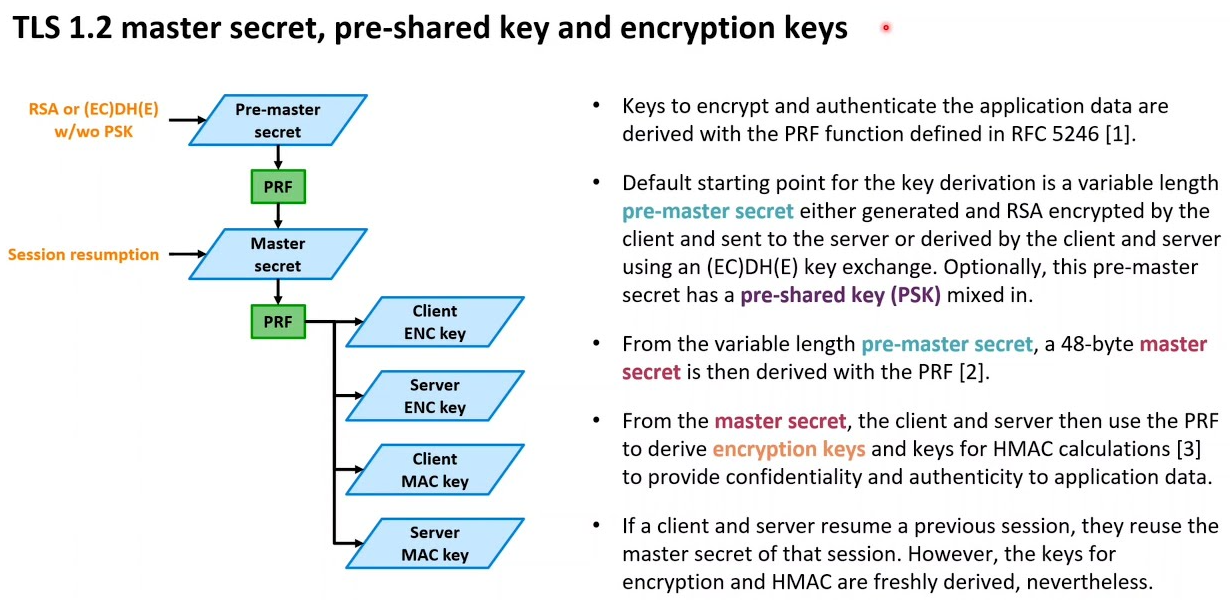

Here, we use a simpler version of creating sessional keys.


Following we illustrate the difference between forward and backward secrecy.

While they are similar, the consequences of which it is protecting against is different.

<b>Forward secrecy</b> guards against the situation that when a key is lost, all data which the data was sniffed and collected by the attacker can be deciphered. Hence, session key is used so that contextually, only the ephermeral data is leaked, but it does not affect the data subjected to another key before it as it is guarded by an ephermeral session key pair. We use RSA for familiarity. Usually, it is ECDHE or EdDHE.

Strong <b>forward secrecy</b> would be necessary to minimize the probability that attacking observers would recognize the existence of participant subjects and know there's an event that had taken place. If an attacker got any related materials the objective is to deter the attacker from tracing to past details. (This is confusing as it seems to be better called as `backward secrecy` instead). The forward is because the session can now be traced going backward from the past to the present due to the session key it is subjected to.

Post-compromise ensures that if the key is leak, the session only holds for a sequence before the ECDHE is reset.

<b>Backward secrecy</b> guards against the situation that when a key is lost in the future, it cannot reach the data protected by the key arrangement in the past backwards. With <b> backward secrecy </b>, we assume that future compromise don't have access to the key. This is sort of like the situation where attackers cannot trace backwards after getting the clues of a key down the line of a future leak, and look for clues as to what happened before they got the leak.

The 3 can share the same mechanisms, but the context of assurance is different.

Double Ratchet reset the ECDHE at every message from each side. The receive and send transmission is a secure channel of its on own on each side, i.e. each send and receive has their own shared symmetric key with the other side. Hence, the protocol needs to be aware of the sequence and which key they keep or which key they delete in order to be able to recover the sequences of messages in order.


Essentially, <b> backward security </b> is cracking backwards, while <b> forward security </b> is cracking forward. <b> Backward secrecy </b> can be deterred by ratcheting, or PRF, while <b> forward secrecy </b> can be deterred by switching keys at the instance to lower the probability of session hijack.

<b>Forward secrecy</b> is a situation such that you change the keys and details going forward, and the attackers can't tell next even if they get the session key now.

<b>Backward secrecy</b> is a situation such that the attackers can't tell before even if they get the session key now.

These are criteria, not means.


In [5]:
import os
import sys
from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives.ciphers.aead import AESGCM

def generate_rsa_keypair(rsa_key_size):
    private_key = rsa.generate_private_key(public_exponent=65537, key_size=rsa_key_size)
    return private_key, private_key.public_key()

def generate_aes_key(aes_key_size):
    return AESGCM.generate_key(bit_length=aes_key_size)

def encrypt_data(data, public_key, aes_key):
    aesgcm = AESGCM(aes_key)
    nonce = os.urandom(12)

    # Encrypt the AES key with RSA
    hash_algorithm = hashes.SHA256()
    encrypted_key = public_key.encrypt(
        aes_key,
        padding.OAEP(mgf=padding.MGF1(algorithm=hash_algorithm), algorithm=hash_algorithm, label=None)
    )

    # Encrypt data with AES key
    encrypted_data = aesgcm.encrypt(nonce, data, None)

    # Format: RSA Encrypted AES Key | Nonce | Encrypted Data
    result = encrypted_key + nonce + encrypted_data
    return result

# encrypted_data = [encrypted_key:N-bits][nonce:typically 12 bytes (96 bits) for AES-GCM][enc_data]
def decrypt_data(encrypted_data, private_key, rsa_key_size):
    encrypted_key = encrypted_data[0:rsa_key_size//8]
    nonce = encrypted_data[rsa_key_size//8:rsa_key_size//8+12]
    enc_data = encrypted_data[rsa_key_size//8+12:]

    # Decrypt the AES key with RSA
    hash_algorithm = hashes.SHA256()
    aes_key = private_key.decrypt(
        encrypted_key,
        padding.OAEP(mgf=padding.MGF1(algorithm=hash_algorithm), algorithm=hash_algorithm, label=None)
    )

    # Decrypt data with the AES key
    aesgcm = AESGCM(aes_key)
    data = aesgcm.decrypt(nonce, enc_data, None)
    return data

def show_private_key(private_key, password):
    sk = private_key.private_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PrivateFormat.PKCS8,
        encryption_algorithm=serialization.BestAvailableEncryption(password.encode())
    )
    s = sk.decode().split("\n")
    for l in s:
        print(l)

def show_public_key(public_key):
    pk = public_key.public_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PublicFormat.SubjectPublicKeyInfo
    )
    s = pk.decode().split("\n")
    for l in s:
        print(l)

import secrets

def generate_random_hex(n):
    # Generate n random bytes
    random_bytes = secrets.token_bytes(n)
    # Convert the bytes to a hex string and return
    return random_bytes.hex()

aes_key_size = 256
rsa_key_size = 2048
password = "secret"
N = 16  # Length of the desired hex string
data_in_plaintext = generate_random_hex(N)
print(f"data_in_plaintext : {data_in_plaintext}")

private_key, public_key = generate_rsa_keypair(rsa_key_size)
aes_key = generate_aes_key(aes_key_size)

data = data_in_plaintext.encode('utf-8')
encrypted_data = encrypt_data(data, public_key, aes_key)

print("Encrypted data: ", encrypted_data.hex())

decrypted_data = decrypt_data(encrypted_data, private_key, rsa_key_size)
print("Decrypted data: ", decrypted_data.decode('utf-8'))

print("\n\n")
#show_private_key(private_key, password)
#show_public_key(public_key)

""" Forward secrecy
# Simulating key session rolling for 2 parties (A and B)
# Here we simplify that the 2 entites also share the same keypair.
Unlike in TLS 1.2, after pre-master key directly obtain from the key exchange (e.g. g^{a.b} ( mod p ) if using Diffie-Hellman, i.e. ECDH),
using pre-master shared secret to derive a ephermeral shared session key (master_secret):

master_secret = PRF(pre_master_secret, "master secret",
                    ClientHello.random + ServerHello.random)
                    [0..47];

Here, we use a simpler version of creating sessional keys.
"""
# Initial AES key
current_aes_key = aes_key

# A sends a message to B
data_a_to_b = "Message from A to B".encode('utf-8')
encrypted_a_to_b = encrypt_data(data_a_to_b, public_key, current_aes_key)
print("Encrypted A to B: ", encrypted_a_to_b.hex())

# Rotate AES key for next transmission (sub-sessional key)
current_aes_key = generate_aes_key(aes_key_size)  # random for now

# B decrypts the message from A
decrypted_a_to_b = decrypt_data(encrypted_a_to_b, private_key, rsa_key_size)
print("Decrypted A to B: ", decrypted_a_to_b.decode('utf-8'))

# B sends a message to A
data_b_to_a = "Message from B to A".encode('utf-8')
encrypted_b_to_a = encrypt_data(data_b_to_a, public_key, current_aes_key)
print("Encrypted B to A: ", encrypted_b_to_a.hex())

# Rotate AES key for next transmission (sub-sessional key)
current_aes_key = generate_aes_key(aes_key_size)  # random for now

# A decrypts the message from B
decrypted_b_to_a = decrypt_data(encrypted_b_to_a, private_key, rsa_key_size)
print("Decrypted B to A: ", decrypted_b_to_a.decode('utf-8'))


data_in_plaintext : 63881829ce6b107b00ba1edd14dd0b70
Encrypted data:  28a38b269a76be65f6b57bd790a9333976d73548b2dfe3f69a859e379113d669883754f64c6bd2f754c690ac14941ecb9fe94ecc3b97f7d59901cb54ab558272747416be0be4178731f8f822946e2c5e99f8ef3bc05a89bc82be5097544c7888551b8e8c8253bb872dac4ccbce4c29948a354501c578b5f3a158130c4585eeaf694ced1470623584a61036d3699cafe742fddb79f7fe5205157e65f06113060dbc782e8a10546de1e2abe7e342ae1ee04b1dea8cd97a3b6d3dc7179ab57391da62e6d8b082bb3cba90d92e489b470edecf4e8af2fb8567967cdff2920c52e649af137063805e6195ddfe9508f6d5e8913515b1aae17a27705eea1f394d7a2f33202e6c2fb3049ae1d0cdf8a0127110a0b488c768efb57576b24c8472c4ac93832443f87d5c6cfdfdb41e12c263ddb398e6bc041e46f847afb6b28b97
Decrypted data:  63881829ce6b107b00ba1edd14dd0b70



Encrypted A to B:  897e45d8ee201a93ed07ede6763f709e5f81d6041ee9fa6bf94d445cd9d20d1f92aaff64da3cf6c313fa8f4f613f626317cbed5d9f95664ba2b155f58efb9836f1a452836ac4e051af134e3e865054c7a9dc3ea46ec28cb155263fc609973ca5d8a29d93bdfc5afa37f93dd084b761de6

Demonstrates the generation of RSA key pairs for 2 parties and the implementation of forward secrecy using ephemeral RSA keys for each session.

Forward Secrecy Simulation: Simulate secure communication between 2 parties using ephemeral keys for each session.

In [2]:
# Generating RSA key pairs for both parties (key exchange mechanism uses RSA rather than ECDH (Elliptic Curve Diffie-Hellman) for illustrative simplicity)
private_key_A, public_key_A = generate_rsa_keypair(rsa_key_size)
private_key_B, public_key_B = generate_rsa_keypair(rsa_key_size)

# Forward secrecy example: Use ephemeral keys for each session
# Session 1: A to B
ephemeral_private_key_A, ephemeral_public_key_A = generate_rsa_keypair(rsa_key_size)
aes_key = generate_aes_key(aes_key_size)
encrypted_data_1 = encrypt_data(data, ephemeral_public_key_A, aes_key)
decrypted_data_1 = decrypt_data(encrypted_data_1, ephemeral_private_key_A, rsa_key_size)

print("Encrypted data (Session 1): ", encrypted_data_1.hex())
print("Decrypted data (Session 1): ", decrypted_data_1.decode('utf-8'))

# Session 2: B to A
ephemeral_private_key_B, ephemeral_public_key_B = generate_rsa_keypair(rsa_key_size)
aes_key = generate_aes_key(aes_key_size)
encrypted_data_2 = encrypt_data(data, ephemeral_public_key_B, aes_key)
decrypted_data_2 = decrypt_data(encrypted_data_2, ephemeral_private_key_B, rsa_key_size)

print("Encrypted data (Session 2): ", encrypted_data_2.hex())
print("Decrypted data (Session 2): ", decrypted_data_2.decode('utf-8'))

#print("\n\n")
#show_private_key(private_key_A, password)
#show_public_key(public_key_A)
#show_private_key(private_key_B, password)
#show_public_key(public_key_B)


Encrypted data (Session 1):  3fd334516d041fa706afd97a03fbff97677709102b41431ec73eebf7e32373d76a77acf1225ded21ce3c264b8696faff9854d105a3d5297641609e00a6af7c99f905be2de2915034732f184b427f5e91be11ccb531c42ffd71a4254c9b732b0ef43fbb625f32134d8191731a27be8f6654b751bc94efa366e0777960fbf0d7284d7f44ab6222cfa0e4f18ea9c5d0d2c937d845c09a651293aa5b39b4e796aa4ae111468b5712cad5ccfe8e3e5205af7d0b73ba10404a4e2216c1d7b436e4f3f2206eddf96e878c16661105279bbb61213fd362d24f056e495faf88ee8da90e84e66e96f997815fd8833410e88b68c745bdbc43d3fe27034250a54b7aa56f6bf30050fe199b6302e165caef615355a5dd1431ab0e2df0bd181907f8c1e77290a1ab1fe648addfb328b517249a0ce059a8aae1839dc5eec808c90a096d
Decrypted data (Session 1):  3f888d9bfbddf0b8b3137ec9f7ad24ca
Encrypted data (Session 2):  7331c0f5a1223682810fdd3f7ce70f899658bb9ea42001560d2d67085b1ce9793a6901d5b517376691429cc1fe2701e2e92b420803ee900e0c2d9bafbee868855b2cfdaa277f9f47a86b1fb61873edd92191827cec95a6eaed37a3ba9418dc9fc97705c65f410e1c54bbd316c369744c92aa00a893f80fceb8e466f

Demonstrates the generation of elliptic curve keys and the key exchange mechanism using Elliptic Curve Diffie-Hellman (ECDH). It also shows how to derive a symmetric AES key from the shared secret using the PBKDF2 key derivation function as a mechanism which we can replace for RSA.

In [3]:
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
import os

# ECDH key generation
private_key_A = ec.generate_private_key(ec.SECP384R1())  # Elliptic Curve key generation
private_key_B = ec.generate_private_key(ec.SECP384R1())  # Another ephemeral key for B
public_key_A = private_key_A.public_key()
public_key_B = private_key_B.public_key()

# ECDH key exchange (shared secret generation)
shared_secret_A = private_key_A.exchange(ec.ECDH(), public_key_B)  # A generates shared secret using B's public key
shared_secret_B = private_key_B.exchange(ec.ECDH(), public_key_A)  # B does the same using A's public key

# The shared secrets should be the same
assert shared_secret_A == shared_secret_B

# Deriving a symmetric key (AES) from the shared secret
salt = os.urandom(16)  # Generate a random salt
iterations = 100000  # You can increase this number for more security
kdf = PBKDF2HMAC(
    algorithm=hashes.SHA256(),
    length=32,
    salt=salt,
    iterations=iterations
)
aes_key = kdf.derive(shared_secret_A)  # Generate AES key from shared secret
print(f"aes_key: {aes_key.hex()}")

aes_key: 71977397a3a03760dfa6efc38cf80333fc3031a66f1e4bc9f636dab39d91ce90


Demonstrates the generation of RSA key pairs for 2 parties and the implementation of secrecy by rotating session keys after each data transmission without ephermeral key arrangement.

In [4]:
# Generate RSA key pairs for both parties A and B
private_key_A, public_key_A = generate_rsa_keypair(rsa_key_size)
private_key_B, public_key_B = generate_rsa_keypair(rsa_key_size)

# Secrecy (without ephermeral key arrangement) example: Rotate session keys after each transmission
# Transmission 1: A to B
aes_key = generate_aes_key(aes_key_size)
encrypted_data_1 = encrypt_data(data, public_key_B, aes_key)
decrypted_data_1 = decrypt_data(encrypted_data_1, private_key_B, rsa_key_size)
print("Encrypted data (Transmission 1):", encrypted_data_1.hex())
print("Decrypted data (Transmission 1):", decrypted_data_1.decode('utf-8'))

# Rotate session key for A after Transmission 1
# Transmission 2: B to A
aes_key = generate_aes_key(aes_key_size)
encrypted_data_2 = encrypt_data(data, public_key_A, aes_key)
decrypted_data_2 = decrypt_data(encrypted_data_2, private_key_A, rsa_key_size)
print("Encrypted data (Transmission 2):", encrypted_data_2.hex())
print("Decrypted data (Transmission 2):", decrypted_data_2.decode('utf-8'))

# Rotate session key for B after Transmission 2
# Transmission 3: A to B
aes_key = generate_aes_key(aes_key_size)
encrypted_data_3 = encrypt_data(data, public_key_B, aes_key)
decrypted_data_3 = decrypt_data(encrypted_data_3, private_key_B, rsa_key_size)
print("Encrypted data (Transmission 3):", encrypted_data_3.hex())
print("Decrypted data (Transmission 3):", decrypted_data_3.decode('utf-8'))

# The keys are rotated after each transmission, so even if a key is compromised later, it won't reveal the data from past sessions.

# Output the public and private keys
#print("\n\n")
#show_private_key(private_key_A, password)
#show_public_key(public_key_A)
#show_private_key(private_key_B, password)
#show_public_key(public_key_B)


Encrypted data (Transmission 1): 2468798f8607dcaed896b7026f8b1a31396d88153fa0875e8195435599bebfd09d96e6a3e3fb4854552c7ad5e5a96eda03fb969095a6b1889c34e99f108af3c009a8cf084639d1ec41046fed68fe8521ffef2786a7473b1a03b93f2e5772cf1bb8b2110d3a6acc29411f8e56c4bfc44bf6e42934bcd50366830f6a96ebf4a9f933f9bafb6ade32b6d68113c2720d713fd4c3d3b55a7c58d68bfd8a10b4f4dc262952bc738ba5ec6cf77b4ae2fb6408ddbcff08b9356b9bf567fa2505607cab7ea3f9ba246ea28693194c60a59e773c69ec95aa36d18658ae6cc7bf223c279d20ba7f67ab93ef3b7b23e6ce18bc2eb34f8ef6637ae308c6a2aecd5018f560cd5c2b1b07eb7fbe8022101ef63e9d0ca44c53c206ad919116e981c1c4186354d4e9544805de4b4c953b03dd603241e003663a125f3d6184b1093abd71c5
Decrypted data (Transmission 1): 3f888d9bfbddf0b8b3137ec9f7ad24ca
Encrypted data (Transmission 2): 0be6b1edaa1dcae5e8c25b0a78230b4808f1f63703b5c6e08aa5b5f83ed62c812d59d2a8451c29c6a3ec84fa1e53d911a8c66a27680046128b18022cd7778af50b3915d203e879a0f8759f3a72d143ba2f77b8794af432a5cd9b23a4ef8607f9a526132c5561b2dc41042499ac5088c0bcb7a4d42b0